# Load libraries

In [ ]:
import numpy as np
import logging
import matplotlib.pyplot as plt
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

from keras.applications.vgg16 import VGG16
from keras.utils import  plot_model
tfkl = tf.keras.layers

# Utilities function

In [ ]:
def plot_accuracy_loss(history,epochs):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(20, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

# Load data

In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
!unzip -q kagglecatsanddogs_3367a.zip
!ls PetImages

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   176M      0  0:00:04  0:00:04 --:--:--  176M
Cat  Dog


# Delete files that are not JPEG File 

In [ ]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


# Generate  TF Dataset

### Hyperparameters

In [ ]:
batch_size = 32
base_learning_rate = 0.001
n_epochs = 5
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)

In [ ]:
image_size = (224, 224)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.1,
    subset="training",
    seed=32,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",#
    validation_split=0.05,
    subset="validation",
    seed=32,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 21069 files for training.
Found 23410 files belonging to 2 classes.
Using 1170 files for validation.


## Visualize some images of the data

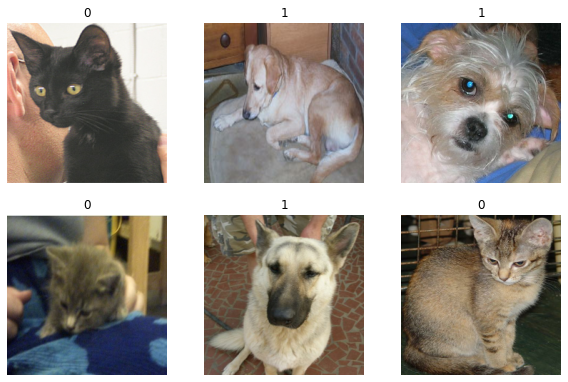

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Preprocess image using pixel scaling

In [ ]:
train_tensor = train_ds.map(lambda image, label: (tfkl.experimental.preprocessing.Rescaling(1./255)(image), label))
test_tensor = val_ds.map(lambda image, label: (tfkl.experimental.preprocessing.Rescaling(1./255)(image), label))

# Modeling of the VGG16 for  binary classification

### Import pre-trained model

553467904/553467096 [==============================] - 4s 0us/step


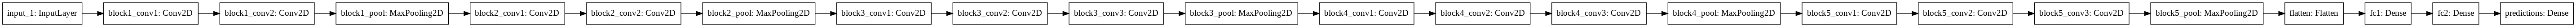

In [ ]:
vgg16_model = keras.applications.vgg16.VGG16()
plot_model(vgg16_model,rankdir="LR")


### Assign pre-trained weights to the sequential model 

In [ ]:
my_vgg = Sequential()

for layer in vgg16_model.layers[:-1]:
    my_vgg.add(layer)    

# Freeze the layers  => train only the last part
for layer in my_vgg.layers:
    layer.trainable = False

my_vgg.add(Dense(1,kernel_initializer='glorot_uniform',bias_initializer='zeros')) # We precise a dense layer of 1 neuron because we're doing binary classifcation  
                  # here we don't add activation because we are going to use BCE Loss 


### Training

In [ ]:
my_vgg.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
my_vgg.summary() ## From the summary, we took care of verify that only the last layer is trainable

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [ ]:

history = my_vgg.fit(train_tensor,
                    epochs=n_epochs,
                    validation_data=test_tensor, 
                    callbacks=[reduce_lr])

Epoch 1/5
659/659 [==============================] - 143s 207ms/step - loss: 0.4223 - accuracy: 0.7814 - val_loss: 0.2633 - val_accuracy: 0.8598
Epoch 2/5
659/659 [==============================] - 127s 192ms/step - loss: 0.2613 - accuracy: 0.8795 - val_loss: 0.2510 - val_accuracy: 0.8641
Epoch 3/5
659/659 [==============================] - 127s 191ms/step - loss: 0.2310 - accuracy: 0.8980 - val_loss: 0.2382 - val_accuracy: 0.8769
Epoch 4/5
659/659 [==============================] - 126s 191ms/step - loss: 0.2207 - accuracy: 0.9013 - val_loss: 0.2521 - val_accuracy: 0.9043
Epoch 5/5
659/659 [==============================] - 126s 191ms/step - loss: 0.2154 - accuracy: 0.9047 - val_loss: 0.2450 - val_accuracy: 0.9077


Here we have ~ 90 % accuracy, but keep in mind that we didn't use data augmentation and didn't tune hyperparameters.

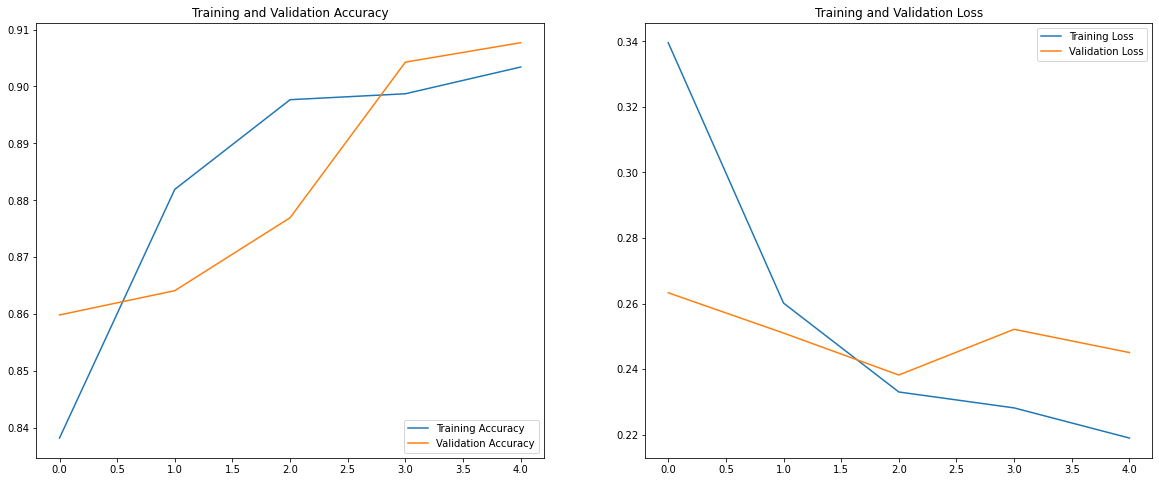

In [ ]:
plot_accuracy_loss(history,n_epochs)

# Split the model architecture recently implemented  on 3 architectures

The goal of this idea, is to simulate a network with 3 classes, where every classes represents a physical node.

## First Node

In [ ]:
class NodeI(tf.keras.layers.Layer):

  def __init__(self):
    super(NodeI, self).__init__()
    self.conv1 = tfkl.Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu")
    self.conv2 = tfkl.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu")

    self.max_pool_1 = tfkl.MaxPool2D(pool_size=(2,2),strides=(2,2))
    self.conv3 = tfkl.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")
    self.conv4 = tfkl.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")
    self.max_pool_2 = tfkl.MaxPool2D(pool_size=(2,2),strides=(2,2))

  def call(self, inputs):
    x = self.conv1(inputs)
    x = self.conv2(x)
    x = self.max_pool_1(x)
    x = self.conv3(x)
    x = self.conv4(x)
    out1 = self.max_pool_2(x)
    

    return out1


## Second Node

In [ ]:
class NodeII(tf.keras.layers.Layer):

  def __init__(self):
    super(NodeII, self).__init__()
    self.conv1 = tfkl.Conv2D(input_shape=(56,56,128),filters=256, kernel_size=(3,3), padding="same", activation="relu")
    self.conv2 = tfkl.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")
    self.conv3 = tfkl.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")

    self.max_pool_1 = tfkl.MaxPool2D(pool_size=(2,2),strides=(2,2))

    self.conv4 = tfkl.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")
    self.conv5 = tfkl.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")
    self.conv6 = tfkl.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")

    self.max_pool_2 = tfkl.MaxPool2D(pool_size=(2,2),strides=(2,2))

  def call(self, inputs):
    x = self.conv1(inputs)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.max_pool_1(x)

    x = self.conv4(x)
    x = self.conv5(x)
    x = self.conv6(x)  

    out2 = self.max_pool_2(x)

    return out2



## Third Node

In [ ]:
class NodeIII(tf.keras.layers.Layer):

  def __init__(self):
    super(NodeIII, self).__init__()

    self.conv1 = tfkl.Conv2D(input_shape=( 14, 14, 512),filters=512, kernel_size=(3,3), padding="same", activation="relu")
    self.conv2 = tfkl.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")
    self.conv3 = tfkl.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")
    self.max_pool = tfkl.MaxPool2D(pool_size=(2,2),strides=(2,2))
    self.flatten = tfkl.Flatten()
    self.dense1 = tfkl.Dense(units=4096,activation="relu")
    self.dense2 = tfkl.Dense(units=4096,activation="relu")
    self.dense3 = tfkl.Dense(units=1)

  def call(self, inputs):
    x = self.conv1(inputs)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.max_pool(x)
    x = self.flatten(x)
    x = self.dense1(x)
    x = self.dense2(x)
    out3 = self.dense3(x)
    return out3




# Test of classes

In [ ]:
data = tf.experimental.numpy.random.rand(1,224,224,3)

In this step, we verify inputs shape but also output shape as they are important and necessary to correctly add the weights that will connect physical node I and III in case  node II fails

In [ ]:
output = NodeI().call(data)

output_2 = NodeII().call(output)

output_3 = NodeIII().call(output_2)

print(" Shape of the input {} \n Output Shape of the first node {} \n Output Shape of the second node {} \n Output Shape of the last node {} ".format(data.shape,output.shape,output_2.shape,output_3.shape))

 Shape of the input (1, 224, 224, 3) 
 Output Shape of the first node (1, 56, 56, 128) 
 Output Shape of the second node (1, 14, 14, 512) 
 Output Shape of the last node (1, 1) 


# The Overall Architecture

Here we implement a new Class that will represents the **overall network** composed of node **I** , **II**, and **III**.


The idea of implementing a new class, is to transfer pre-trained weights of the previous model we trained in this one. Furthermore, it allows every class (node **I** , **II**, and **III**)  to have its own pre-trained weights

In [ ]:
class my_VGG16(tf.keras.Model):

  def __init__(self):
    super(my_VGG16, self).__init__()
    self.node_1 = NodeI()
    self.node_2 = NodeII()
    self.node_3 = NodeIII()



  def call(self, inputs):
    out_1 = self.node_1(inputs) # physical node I

    out_2 = self.node_2(out_1)  # physical node II
    
    out_3 = self.node_3(out_2)  # physical node III


    return out_3


In [ ]:
vgg_class = my_VGG16()
vgg_class.build((1,224,224,3))

vgg_class.summary()

Model: "my_vg_g16_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
node_i_3 (NodeI)             multiple                  260160    
_________________________________________________________________
node_ii_2 (NodeII)           multiple                  7375104   
_________________________________________________________________
node_iii_2 (NodeIII)         multiple                  126629377 
Total params: 134,264,641
Trainable params: 134,264,641
Non-trainable params: 0
_________________________________________________________________


# Assigning pretrained weights to the  class architecture

In [ ]:
vgg_class.set_weights(my_vgg.get_weights())

# Weights assert and verification  

In [ ]:
try:
  assert vgg_class.node_1.weights == vgg_class.weights[0:8]   ## 0-8  => weights of node I
  assert vgg_class.node_2.weights == vgg_class.weights[8:20]  ## 8-19 => weights of node II
  assert vgg_class.node_3.weights == vgg_class.weights[20:32] ## 20-31 => weights of node II
  print("Success, all weights of the  pre-trained model has been correctly distributed on every node")
except AssertionError:
    logging.error("Error occurs, dimensions don't match or weights are not equal", exc_info=True)


Success, all weights of the  pre-trained model has been correctly distributed on every node


The idea behind implementing this intermediate class is to exploit and and be able to use its  pre-trained **instances**  which are : 



1.   self.node_1
2.   self.node_2
3.   self.node_3


That belongs to the **my_VGG16** class



# Setting the problem situation

In [ ]:
%%bash
wget  -nv -O chain.png https://user-images.githubusercontent.com/55285736/110709957-5ce2ab80-81fd-11eb-82b9-7dc752e8486c.png

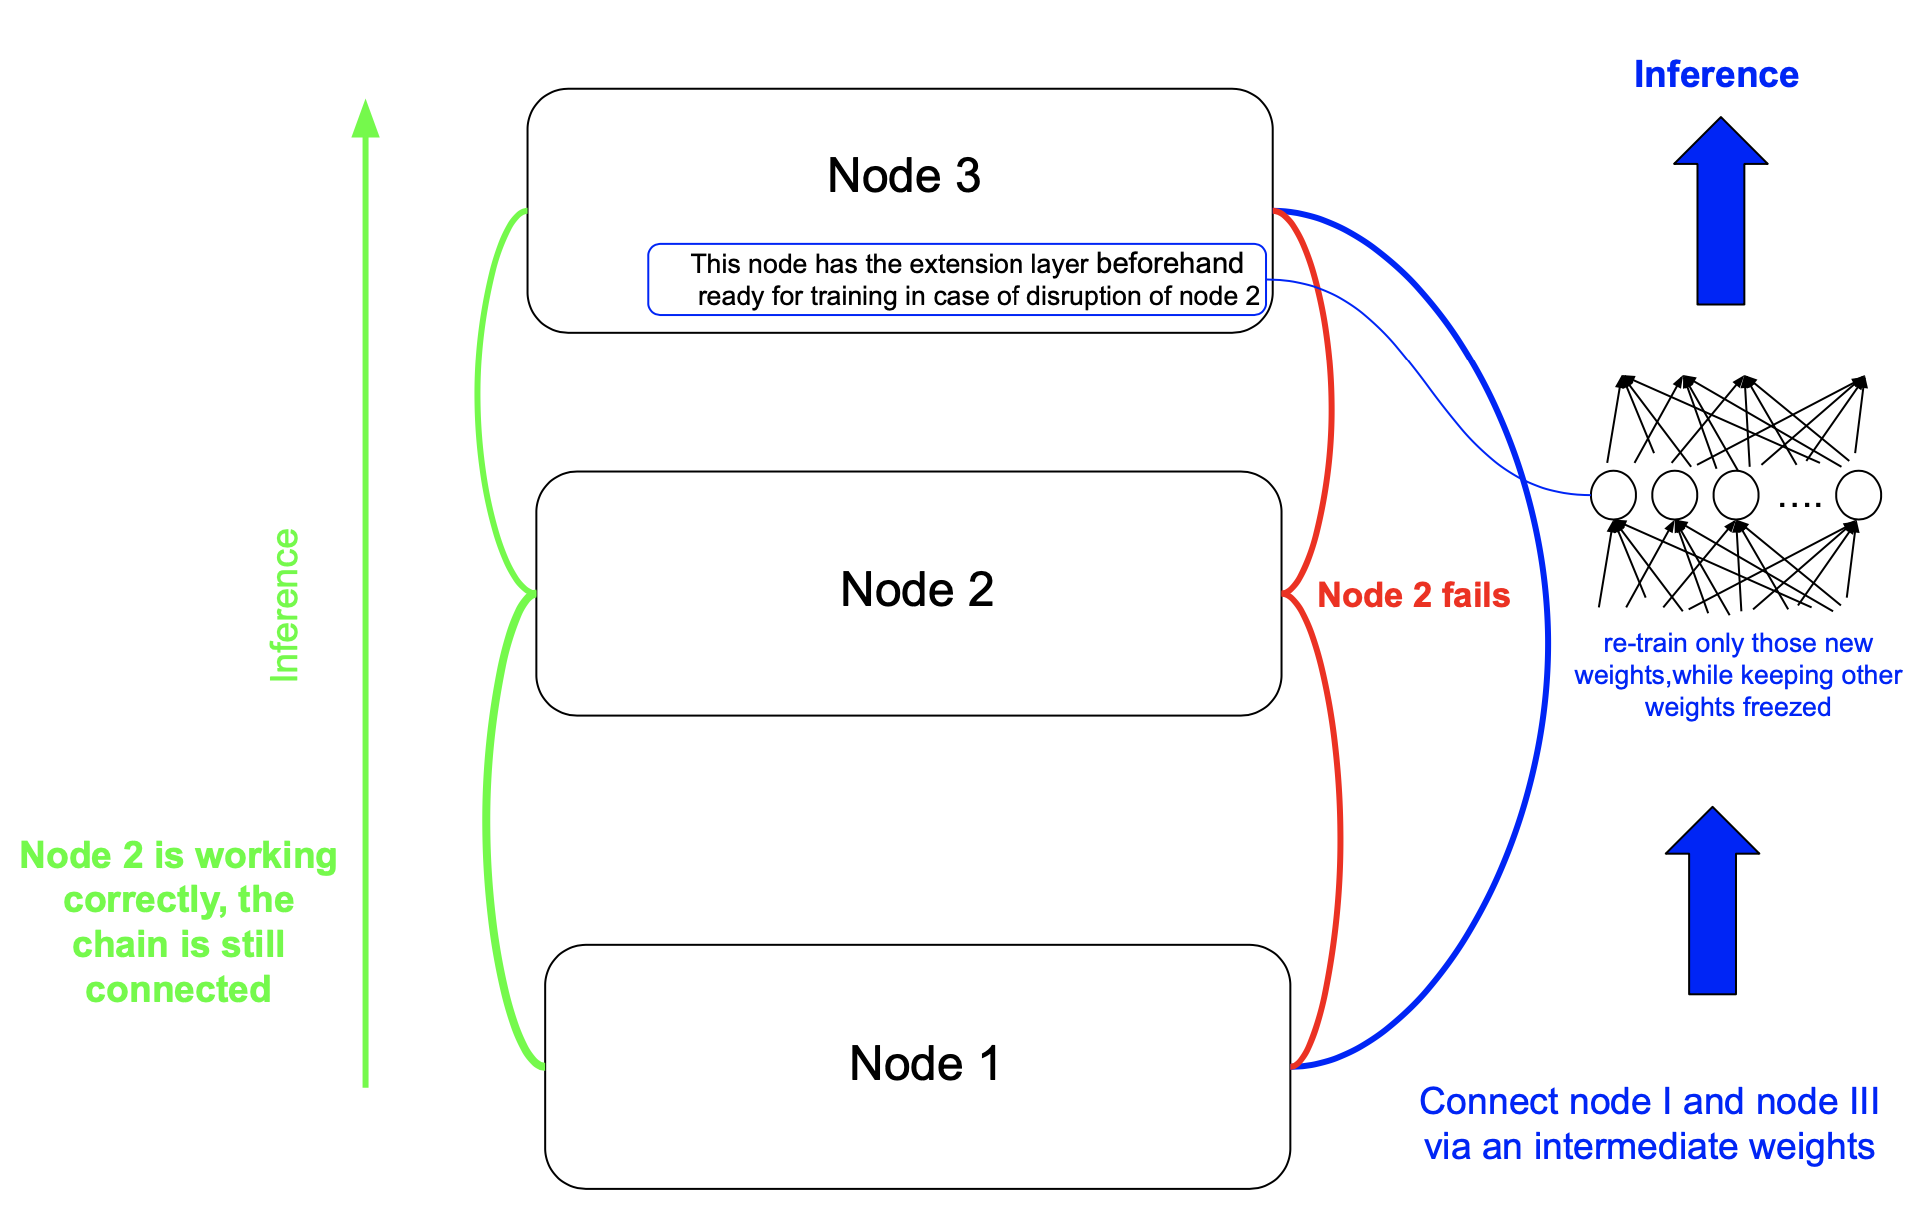

In [ ]:
from IPython.display import Image
Image('chain.png',width=1400, height=1000)

# Inherit from the VGG16 Class + extension layer

- Here we need to make trainable :

  • The extension layer that add resiliency to the model because the node 2 crashes


- While keeping freezed :

  • node I weights inherited from VGG16 we trained.

  • node III weights inherited from VGG16 too.

In [ ]:
class vgg_extension(tf.keras.Model):

  def __init__(self):
    super(vgg_extension, self).__init__()
    self.node_1 = vgg_class.node_1
    self.node_3 = vgg_class.node_3

    self.rshp = tfkl.Reshape((14,14,2048), input_shape=(56,56,128))
    self.extension_layer = tfkl.Dense(512,activation="relu",kernel_initializer='glorot_uniform',bias_initializer='zeros') # Here the activation functionn may be an hyper-parameter
    self.extension_layer.trainable = True
    self.node_1.trainable = False
    self.node_3.trainable = False




    self.extension_layer.trainable=True

  def call(self, inputs):


    out_1 = self.node_1(inputs)
    out_1_new = self.rshp(out_1)
    ext = self.extension_layer(out_1_new)
    new_out = self.node_3(ext)



    return new_out


In a network connection, if a node failed it is identified by no response from ICMP packets from the previous and next node

Here we consider, the Node II as the physical node 2, its existence means that the network connection is not disrupted and that the chain is working correctly.


But if the node II fails, identified by the non-existence / absence   of the class representing the node 2, we're going to retrain the weights that will let the node 1 and node 3 re-connect, while keeping the other overall weights of the networks freezed and unchanged

In [ ]:
#del NodeII   

# FIRST STEP :
## don't execute this command, and execute the next cell


# SECOND STEP : 
## After executing the next cell, now simulate a crash of the node II by UNCOMMENT the first line, then execute this cell and the next

In [ ]:
if  'NodeII' in dir():

  print("Do inference, there is no break in the chain, the node didn't fail")
  for images, labels in test_tensor.take(1):

    targets = my_vgg(images)     # inference
  loss, accuracy = my_vgg.evaluate(test_tensor)
  print("Accuracy", accuracy)
  print("label of a batch of targets{}".format(tf.keras.layers.Softmax()(targets)))



else: #del NodeII in the case of a disrupt in the chain, at the level of node 2
  print("The node failed ! \n")
  my_model = vgg_extension()

  my_model.build((1,224,224,3)),my_model.rshp.build((1,56,56,128)),my_model.extension_layer.build((1,56,56,2048))

  print("Re-train the model with the extension layer, with keeping the weights of nodes 1 and 3  freezed")

  my_model.summary()


  print("Compilation of the model.....")

  my_model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])

  print("Training......")

  history_2 = my_model.fit(train_tensor,
                      epochs=n_epochs,
                      validation_data=test_tensor,
                       callbacks=[reduce_lr]) 
  print("Finish")

  print("Inference after training")

  for images, labels in test_tensor.take(1):

    targets = my_model(images)     # inference
  loss, accuracy = my_model.evaluate(test_tensor)
  print("Accuracy", accuracy)
  print("label of a batch of targets{}".format(tf.keras.layers.Softmax()(targets)))




The node failed ! 

Re-train the model with the extension layer, with keeping the weights of nodes 1 and 3  freezed
Model: "vgg_extension_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
node_i_2 (NodeI)             multiple                  260160    
_________________________________________________________________
node_iii_1 (NodeIII)         multiple                  126629377 
_________________________________________________________________
reshape_9 (Reshape)          multiple                  0         
_________________________________________________________________
dense_26 (Dense)             multiple                  1049088   
Total params: 127,938,625
Trainable params: 1,049,088
Non-trainable params: 126,889,537
_________________________________________________________________
Compilation of the model.....
Training......
Epoch 1/5
659/659 [==============================] - 101s 152ms/st

We can notice that the new architecture took less time to train compared to the first one.

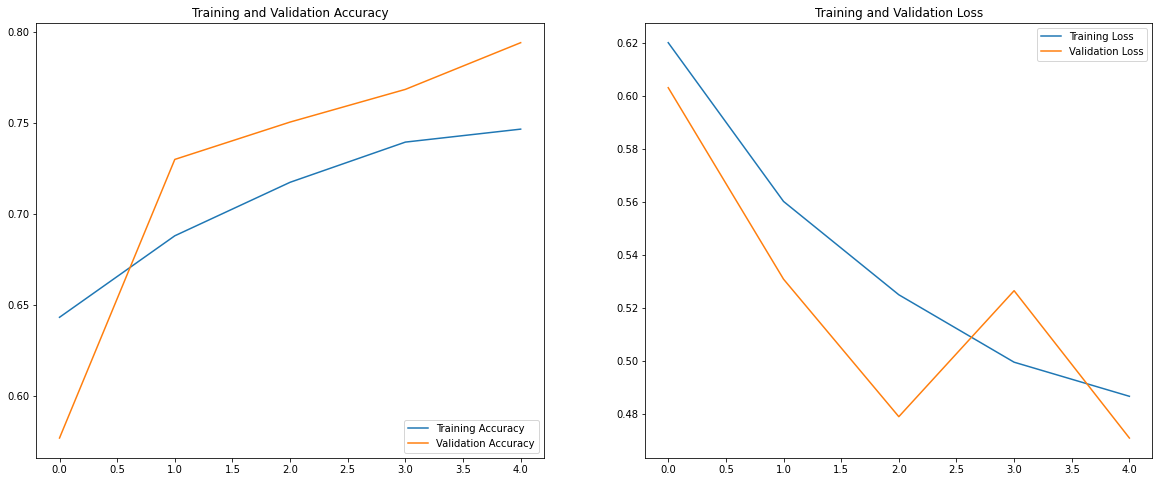

In [ ]:
plot_accuracy_loss(history_2,n_epochs)

Here we obtain an accuracy of 80%, knowing that :

1• **we dropped more than 1/3 of the original model**

2• **we train for only 5 epochs** 

3• **We didn't fine tune hyper-parameters**

In a case where the node  II would have only one layer, the accuracy would be very similar to the first model we create.

# Remark

WE could use a layer convolution to connect the nodes, but we would need **512 filters of 43x43**. This layer have almost the same number of  parameters than the  number of VGG16 parameters, making this alternative solution **not suitable | impossible** for our task as we need as less as possible  parameters because we're talking about Internet of Things, which might not be able to handle this huge number of parameters.

In [ ]:
conv = tfkl.Conv2D(512,43)
conv.build((1,56,56,128)) # shape of the output of the node 1
conv(output).shape == output_2.shape

conv.count_params()

121176576